In [1]:
%pwd

'/jet/home/mtragoza/ipython-notebooks/batman_lab'

In [2]:
%load_ext autoreload
%matplotlib inline
import sys, os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../deepxde/')
os.environ['DDEBACKEND'] = 'pytorch'
import deepxde
deepxde

Using backend: pytorch



<module 'deepxde' from '/jet/home/mtragoza/ipython-notebooks/batman_lab/../../deepxde/deepxde/__init__.py'>

# 2D inverse Helmholtz problem

We would like to solve an inverse problem for a *two-dimensional* Helmholtz equation:

$$
\begin{align}
    G \nabla^2 u &= -\rho \omega^2 u \\
    G \left(\frac{\partial^2 u}{\partial x_1^2} + \frac{\partial^2 u}{\partial x_2^2} \right) &= -\rho \omega^2 u
\end{align}
$$

Where the goal is to recover $G(x)$ given a training data set of $((x, u(x))$ pairs. First, we will create a true stiffness function and solve the forward problem to obtain a wave field. Then we will compare two different methods of reconstructing the elasticity from the wave field: iterative inversion and PINNs.

## Solving the forward problem

Given some true stiffness function $G(x)$ and boundary conditions, we can solve for the displacement (i.e. the forward problem) using finite differences:

$$
\begin{align}
    G \left(\frac{\partial^2 u}{\partial x_1^2} + \frac{\partial^2 u}{\partial x_2^2} \right) &= -\rho \omega^2 u \\
    G_{i,j} \left( \frac{u_{i+1,j} - 2 u_{i,j} + u_{i-1,j}}{h^2} + \frac{u_{i,j+1} - 2 u_{i,j} + u_{i,j-1}}{h^2} \right) &= -\rho \omega^2 u_{i,j} \\
    G_{i,j} \left( \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4 u_{i,j}}{h^2} \right) &= -\rho \omega^2 u_{i,j} \\
    G_{i,j} \left( \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4 u_{i,j}}{h^2} \right) + \rho \omega^2 u_{i,j} &= 0 \\
    \left( \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4 u_{i,j}}{h^2} \right) + \rho \omega^2 \frac{u_{i,j}}{G_{i,j}} &= 0 \\
    \mathbf{L} \mathbf{u} + \rho \omega^2 \mathbf{G} \mathbf{u} &= 0 \\
    \left( \mathbf{L} + \rho \omega^2 \mathbf{G} \right) \mathbf{u} &= 0 \\
    \mathbf{A} \mathbf{u} &= 0
\end{align}
$$

We will use this approach to define a reference solution to the PDE for training the model.

In [3]:
# functions for defining a 2d discrete Laplacian matrix

def tridiag(a, b, c, n, **kwargs):
    ones = torch.ones(n-1, **kwargs)
    return (
        a * torch.diag(ones, diagonal=-1) +
        b * torch.eye(n, **kwargs) + 
        c * torch.diag(ones, diagonal=1)
    )

def laplacian_matrix_2d(n_x, dx, **kwargs):
    rows = []
    for i in range(n_x):
        row = []
        for j in range(n_x):
            diag = abs(i - j)
            if diag == 0:
                m = tridiag(1, -4, 1, n_x, **kwargs)
            elif diag == 1:
                m = torch.eye(n_x, **kwargs)
            else:
                m = torch.zeros((n_x, n_x), **kwargs)
            row.append(m)
        rows.append(torch.cat(row, dim=1))
    return torch.cat(rows, dim=0) / dx**2

def print_mat(**kwargs):
    for k, v in kwargs.items():
        v_str = str(v).replace('\n', '\n')
        print(f'{k} = \n{v_str}')

L = laplacian_matrix_2d(n_x=3, dx=1)
print_mat(L=L)

L = 
tensor([[-4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -4.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0., -4.,  1.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  1., -4.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  1., -4.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  0., -4.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  1., -4.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -4.]])


In [76]:
# implicit method using block tridiagonal linear system

def implicit_solver_2d(x, n_x, dx, G, u0, rho, omega, **kwargs):

    # set up linear system
    L = laplacian_matrix_2d(n_x, dx)
    G = torch.diag(1 / G[:,0])

    A = L + rho * omega**2 * G
    b = torch.zeros(n_x**2, **kwargs)
    
    # determine boundary nodes
    on_boundary = (torch.abs(x).max(dim=1)[0] == 1.0)
    
    # set boundary conditions
    A[on_boundary,:] = 0
    A[on_boundary,on_boundary] = 1
    b[on_boundary] = u0[on_boundary,0]
    
    # solve linear system
    u = torch.linalg.solve(A, b)

    return u.reshape(-1, 1)

# define the reference solution

def solution(x, n_x, dx, rho, omega, **kwargs):
    '''
    Compute reference solution.
    '''    
    # true stiffness function
    G = torch.ones((n_x**2, 1), **kwargs) * rho
    
    locs = torch.tensor([
        [-0.5,  0.5],
        [ 0.5,  0.5],
        [-0.5, -0.5],
        [ 0.5, -0.5]
    ], **kwargs)
    
    G = G + torch.exp(-((x - locs[0])**2).sum(dim=1, keepdim=True)*100) *  rho * 3
    G = G + torch.exp(-((x - locs[1])**2).sum(dim=1, keepdim=True)*100) * -rho / 2
    G = G + torch.exp(-((x - locs[2])**2).sum(dim=1, keepdim=True)*100) * -rho / 2
    G = G + torch.exp(-((x - locs[3])**2).sum(dim=1, keepdim=True)*100) *  rho

    # solve for displacement field
    phi = torch.rand((1, 1), **kwargs) * 2 * np.pi # random phase offset
    u = torch.sin(omega * (x[:,1:2] + phi))
    u = implicit_solver_2d(x, n_x, dx, G, u, rho, omega, **kwargs)  

    return u, G

# define the training data set

rho = 1
omega = 4 * np.pi

def gen_train_data(n_x, **kwargs):
    '''
    Generate training data for PDE.
    '''
    x = torch.linspace(-1, 1, n_x, **kwargs)
    dx = x[1] - x[0]
    x = torch.cartesian_prod(x, x)
    u, G = solution(x, n_x, dx, rho, omega, **kwargs)
    return x, u, G

n_train = 100 # training points along each dimension

x, u_true, G_true = gen_train_data(n_train, device='cuda')

print(x.shape, u_true.shape, G_true.shape)

torch.Size([10000, 2]) torch.Size([10000, 1]) torch.Size([10000, 1])


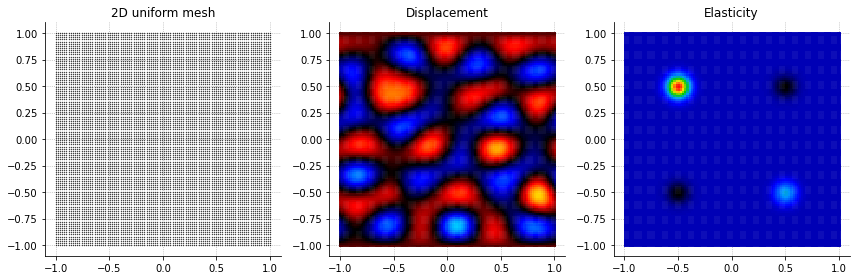

In [77]:
import matplotlib as mpl

def phase_color_map():
    '''
    Create a colormap for MRE wave images
    from yellow, red, black, blue, to cyan.
    '''
    cyan   = (0, 1, 1)
    blue   = (0, 0, 1)
    black  = (0, 0, 0)
    red    = (1, 0, 0)
    yellow = (1, 1, 0)

    colors = [cyan, blue, black, red, yellow]

    return mpl.colors.LinearSegmentedColormap.from_list(
        name='wave', colors=colors, N=255
    )

def elast_color_map():
    '''
    Create a colormap for MRE elastrograms
    from dark, blue, cyan, green, yellow, to red.
    '''
    p = 0.0
    c = 0.6
    y = 0.9
    g = 0.8

    dark = (p, 0, p)
    blue   = (0, 0, 1)
    cyan   = (0, c, 1)
    green  = (0, g, 0)
    yellow = (1, y, 0)
    red    = (1, 0, 0)

    colors = [dark, blue, cyan, green, yellow, red]

    return mpl.colors.LinearSegmentedColormap.from_list(
        name='wave', colors=colors, N=255
    )

phase_cmap = phase_color_map()
elast_cmap = elast_color_map()

def plot_2d(x, u, G):
    
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    size = 25000 / n_train**2
    
    # plot mesh
    ax = axes[0]
    ax.set_title('2D uniform mesh')
    ax.scatter(x[:,0], x[:,1], color='black', s=size/20)
    
    # plot displacement
    ax = axes[1]
    ax.set_title('Displacement')
    ax.scatter(x[:,0], x[:,1], c=u[:,0], cmap=phase_cmap, marker='s', s=size, vmin=-3, vmax=3)
    
    # plot stiffness
    ax = axes[2]
    ax.set_title('Elasticity')
    ax.scatter(x[:,0], x[:,1], c=G[:,0], cmap=elast_cmap, marker='s', s=size)
               
    for ax in axes:
        ax.set_axisbelow(True)
        ax.grid(True, linestyle=':')

    sns.despine(fig)
    fig.tight_layout()

plot_2d(x.cpu().numpy(), u_true.cpu().numpy(), G_true.cpu().numpy())

## Physics-informed neural network

We will use DeepXDE to solve the PDE inverse problem on the rectangle $x \in \left[-1, 1\right]^2$ using a neural network.

Given some candidate solution $(\hat{u}, \hat{G})$, we can rearrange the PDE to obtain a residual:

$$
\begin{align}
    G \nabla^2 u &= -\rho \omega^2 u \\
    0 &= G \nabla^2 u + \rho \omega^2 u \\
    r(x, \hat{u}, \hat{G}) &= \hat{G} \nabla^2 \hat{u} + \rho \omega^2 \hat{u}
\end{align}
$$

We will train a neural network to minimize this residual, subject to constraints in the form of a set of training data points of $(x, u(x))$.

In [78]:
# define the geometry (i.e. domain of x)

geom = deepxde.geometry.Rectangle([-1, -1], [1, 1])
print(geom)
print(f'dim = {geom.dim}\nbbox = {geom.bbox}\nperimeter = {geom.perimeter}\narea = {geom.area}')

# define the residual of the PDE

def pde(x, u_G):
    '''
    Compute PDE residual.
    '''
    u, G = u_G[:,0:1], u_G[:,1:2]
    u_xx = deepxde.grad.hessian(
        ys=u, # output tensor of shape (batch_size, dim_y)
        xs=x, # input tensor of shape (batch_size, dim_x)
        component=None, # index into dim_y
        i=0, j=0 # indices into dim_x
    )
    u_yy = deepxde.grad.hessian(
        ys=u, # output tensor of shape (batch_size, dim_y)
        xs=x, # input tensor of shape (batch_size, dim_x)
        component=None, # index into dim_y
        i=1, j=1 # indices into dim_x
    )
    return G * (u_xx + u_yy) + rho * omega**2 * u

# define the boundary conditions

point_set = deepxde.icbc.PointSetBC(
    points=x.cpu().numpy(), # array of points where target values are known
    values=u_true.cpu().numpy(), # array of values of the exact solution
    component=0
)

# data combines the geometry, PDE residual, and boundary conditions

n_domain =  200 # random samples in domain for PDE loss
n_test   = 1000 # test evaluation points

data = deepxde.data.PDE(
    geometry=geom, # an instance of Geometry
    pde=pde, # a global PDE or a list of PDEs
    bcs=[point_set], # a boundary condition or list of boundary conditions
    num_domain=n_domain,
    anchors=x.cpu().numpy(), # array of training points in addition to num_domain and num_boundary points
    num_test=n_test # number of points sampled inside the boundary the domain for testing
)

dim = 2
bbox = (array([-1., -1.], dtype=float32), array([1., 1.], dtype=float32))
perimeter = 8.0
area = 4.0


In [79]:
# define the neural network architecture

n_layers = 5
n_hidden = 128
activ_fn = 'sin'

net = deepxde.nn.PFNN(
    layer_sizes=[2] + [[n_hidden, n_hidden]] * (n_layers-1) + [2],
    activation=activ_fn,
    kernel_initializer="Glorot uniform"
)
net

PFNN(
  (layers): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): Linear(in_features=2, out_features=128, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (4): ModuleList(
      (0): Linear(in_features=128, out_features=1, bias=True)
      (1): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [133]:
model = deepxde.Model(data, net)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-5, 1]
)

Compiling model...
'compile' took 0.034419 s



In [134]:
loss_history, train_state = model.train(epochs=20000)

Training model...

0         [2.17e-03, 9.43e-01]    [2.01e-03, 9.43e-01]    []  
1000      [1.21e-03, 1.05e-03]    [9.97e-04, 1.05e-03]    []  
2000      [4.29e-04, 4.28e-04]    [3.97e-04, 4.28e-04]    []  
3000      [4.33e-04, 6.41e-04]    [4.29e-04, 6.41e-04]    []  
4000      [6.07e-04, 8.58e-04]    [6.34e-04, 8.58e-04]    []  
5000      [3.79e-04, 5.40e-04]    [3.88e-04, 5.40e-04]    []  
6000      [1.09e-04, 8.46e-05]    [1.06e-04, 8.46e-05]    []  
7000      [2.42e-04, 5.66e-04]    [2.52e-04, 5.66e-04]    []  
8000      [7.73e-05, 8.52e-05]    [7.59e-05, 8.52e-05]    []  
9000      [2.68e-04, 8.10e-04]    [2.81e-04, 8.10e-04]    []  
10000     [8.59e-05, 1.17e-04]    [8.55e-05, 1.17e-04]    []  
11000     [9.14e-05, 2.74e-04]    [9.37e-05, 2.74e-04]    []  
12000     [8.96e-05, 1.85e-04]    [8.78e-05, 1.85e-04]    []  
13000     [1.47e-04, 5.38e-04]    [1.53e-04, 5.38e-04]    []  
14000     [2.85e-05, 3.55e-05]    [2.76e-05, 3.55e-05]    []  
15000     [1.42e-04, 2.04e-04]    [1

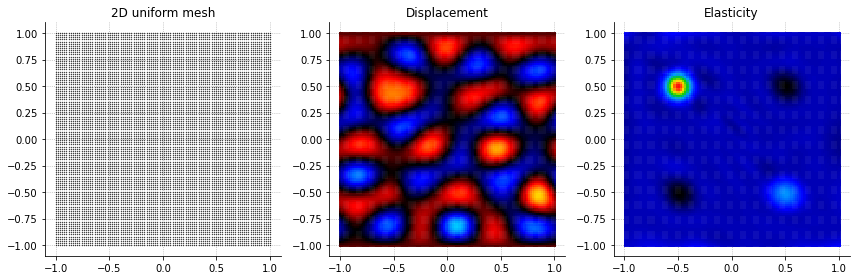

In [135]:
# view results

u_G_pred = model.predict(x.detach().cpu())
u_pred, G_pred = u_G_pred[:, 0:1], u_G_pred[:, 1:2]

plot_2d(
    x.detach().cpu(),
    u_pred, G_pred
)

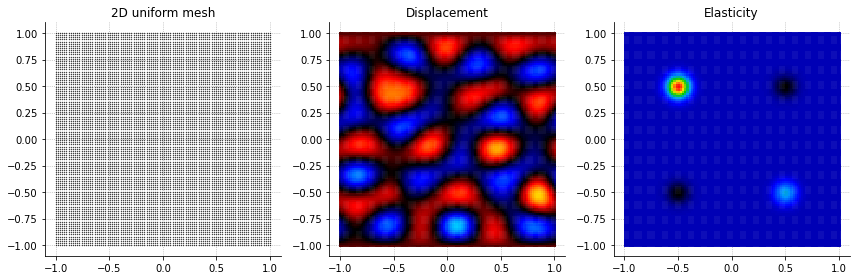

In [136]:
plot_2d(x.detach().cpu(), u_true.detach().cpu(), G_true.detach().cpu())

## Iterative method

Another method for solving the inverse problem is to formulate it as a minimization task:

$$
\begin{align}
    G^* = \operatorname{argmin}_{\hat{G}} \mathcal{L}(\hat{G})
\end{align}
$$

Where the objective being minimized could be, for instance, the sum of squared error:

$$
    \mathcal{L}(\hat{G}) = \| \hat{u}(x; \hat{G}) - u(x) \|^2
$$

Where $\hat{u}(x; \hat{G})$ denotes the wave field obtained by solving the forward problem given the stiffness estimate $\hat{G}$. Thus, the method minimizes the error between the empirical wave field and the one produced by solving the forward problem for a given estimate of the stiffness function, which are now a set of parameters.

We can derive a gradient descent update step for the stiffness parameters $\hat{G}$:

$$
    \hat{G}_{n+1} = \hat{G}_n - \alpha \nabla \mathcal{L}(\hat{G})
$$

Which requires evaluating the gradient of the displacement estimate wrt the stiffness estimate:

$$
\begin{align}
    \nabla \mathcal{L}(\hat{G}) &= \nabla \hat{u}^\top \left( \hat{u}(x; \hat{G}) - u(x) \right) \\
\end{align}
$$

A requirement for this method is that the forward solver is continuous and differentiable with respect to the input coordinates.

In [123]:
def implicit_solver_2d(x, n_x, dx, G, u0, rho, omega, **kwargs):

    # set up linear system
    L = laplacian_matrix_2d(n_x, dx)
    G = torch.diag(1 / G[:,0])

    A = L + rho * omega**2 * G
    b = torch.zeros(n_x**2, **kwargs)

    # determine boundary nodes
    on_boundary = (torch.abs(x).max(dim=1)[0] == 1.0)
    
    # set boundary conditions
    A[on_boundary,:] = 0
    A[on_boundary,on_boundary] = 1
    b[on_boundary] = u0[on_boundary,0]
    
    # solve linear system
    u = torch.linalg.solve(A, b)

    return u.reshape(-1, 1)

def iterative_inversion_2d(x, n_x, dx, G0, i, u, rho, omega, n_iters=500, lr=1e-2, reg=0, **kwargs):
    
    G_pred = torch.nn.Parameter(G0)
    optimizer = torch.optim.Adam([G_pred], lr=lr)
    
    for i in range(i, i+n_iters):
        
        def closure():
            optimizer.zero_grad()
            u_pred = implicit_solver_2d(x, n_x, dx, G_pred, u, rho, omega, **kwargs)
            loss = torch.nn.functional.mse_loss(u_pred, u) + reg * torch.sum(G_pred**2)
            if (i+1) % 50 == 0:
                print(i+1, loss.item())
            loss.backward()
            return loss
        
        optimizer.step(closure)
        
    u_pred = implicit_solver_2d(x, n_x, dx, G_pred, u, rho, omega, **kwargs)  
    return u_pred, G_pred, i

n_x = n_train
dx = x[0,1] - x[1,1]

G_pred = torch.normal(1, 0.1, (n_train**2, 1), device='cuda')
u_pred = implicit_solver_2d(x, n_x, dx, G_true, u_true, rho, omega, device='cuda')
i = 0

In [ ]:
u_pred, G_pred, i = iterative_inversion_2d(x, n_train, dx, G_pred, i, u_true, rho, omega, n_iters=4000, device='cuda')

1000 0.41903120279312134
1050 0.021890481933951378
1100 0.014168299734592438
1150 0.00990340393036604
1200 0.007180224638432264
1250 0.005360596347600222
1300 0.004129547160118818
1350 0.003285421757027507
1400 0.002699753036722541
1450 0.002286578994244337
1500 0.0019499295158311725
1550 0.001695596263743937
1600 0.0015166585799306631
1650 0.0013361668679863214
1700 0.0012199420016258955


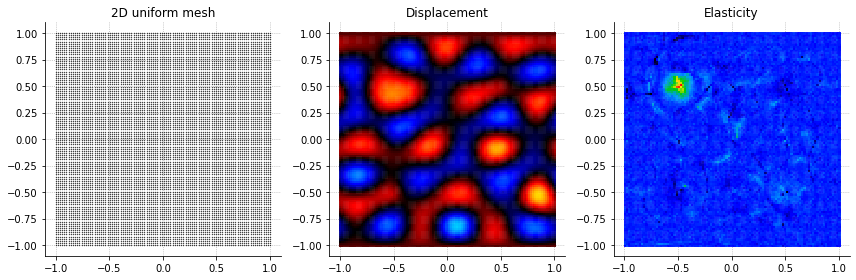

In [131]:
plot_2d(x.detach().cpu(), u_pred.detach().cpu(), G_pred.detach().cpu())

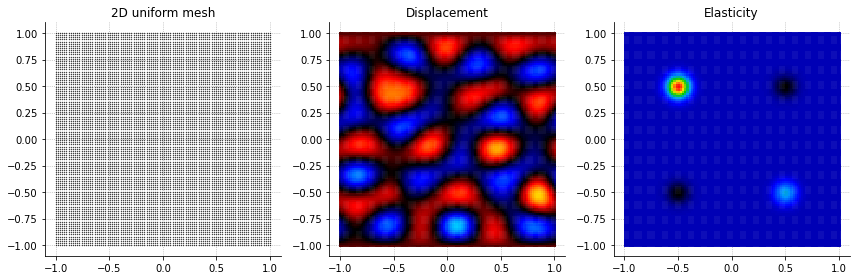

In [132]:
plot_2d(x.detach().cpu(), u_true.detach().cpu(), G_true.detach().cpu())